<a href="https://colab.research.google.com/github/HxyScotthuang/Protein_folding/blob/master/cde_protein_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to produce a neural-cde based protein folding solver. Given the input sequence of amino acid, we can convert it into the one-hot encoding, and output the corrosponding path by torsion angle in-order to have a better inductive bias

# Initialization

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/")

In [113]:
!pip install torchcde
!pip install Biopython
!pip install PeptideBuilder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import torch
import torchcde
import numpy as np
import Bio
import math
from Bio.PDB import *
import torch.utils.data as Data
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob

In [115]:
# Get the pdb-file for alpha_protein: a type of protein that mainly contain alpha-helix
text_file = open("/content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/alphaprotein_list.txt", "r")
PDB_list = text_file.read().split(',')
#print(PDB_list)

In [116]:
# Download data
'''Selecting structures from PDB'''
parser = PDBParser(QUIET=True)
pdbl = PDBList( )
pdbl.retrieve_pdb_file("6sii",pdir='ProteinPDB/AlphaProtein',file_format='pdb')
#for i in PDB_list:
    #pdbl.retrieve_pdb_file(i,pdir='ProteinPDB/AlphaProtein',file_format='pdb')

Structure exists: 'ProteinPDB/AlphaProtein/pdb6sii.ent' 


'ProteinPDB/AlphaProtein/pdb6sii.ent'

In [117]:
# You can use a dict to convert three letter code to one letter code
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

# Extract X, the feature

In [118]:
phys_dic = {'A': [1.28, 0.05, 1.00, 0.31, 6.11, 0.42, 0.23],
            'C': [1.77, 0.13, 2.43, 1.54, 6.35, 0.17, 0.41],
            'D': [1.60, 0.11, 2.78, -0.77, 2.95, 0.25, 0.20],
            'E': [1.56, 0.15, 3.78, -0.64, 3.09, 0.42, 0.21],
            'F': [2.94, 0.29, 5.89, 1.79, 5.67,0.30, 0.38],
            'G': [0.00, 0.00, 0.00, 0.00, 6.07, 0.13, 0.15],
            'H': [2.99, 0.23, 4.66, 0.13, 7.69, 0.27, 0.30],
            'I': [4.19, 0.19, 4.00, 1.80, 6.04, 0.30, 0.45],
            'K': [1.89, 0.22, 4.77, -0.99, 9.99, 0.32, 0.27],
            'L': [2.59, 0.19, 4.00, 1.70, 6.04, 0.39, 0.31],
            'M': [2.35, 0.22, 4.43, 1.23, 5.71, 0.38, 0.32],
            'N': [1.60, 0.13, 2.95, -0.60, 6.52, 0.21, 0.22],
            'P': [2.67, 0.00, 2.72, 0.72, 6.80, 0.13, 0.34],
            'Q': [1.56, 0.18, 3.95, -0.22, 5.65, 0.36, 0.25],
            'R': [2.34, 0.29, 6.13, -1.01, 10.74, 0.36, 0.25],
            'S': [1.31, 0.06, 1.60, -0.04, 5.70, 0.20, 0.28],
            'T': [3.03, 0.11, 2.60, 0.26, 5.60, 0.21, 0.36],
            'V': [3.67, 0.14, 3.00, 1.22, 6.02, 0.27, 0.49],
            'W': [3.21, 0.41, 8.08, 2.25, 5.94, 0.32, 0.42],
            'X': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
            'Y': [2.94, 0.30, 6.47, 0.96, 5.66, 0.25, 0.41]}

In [119]:
def extract_phyChem_prop(target,target_file,phys_dic ,path = './test_data/'):
    target_list = None
    with open(path + f"{target}/{target_file}.seq",'r') as f:
        for i,item in enumerate(f):
          if i == 1:
            target_list = list(item)
    return torch.tensor([phys_dic[res] for res in target_list])

In [120]:
extract_phyChem_prop("pdb1a00","pdb1a00-l64_s0",phys_dic = phys_dic).size()

torch.Size([64, 7])

In [121]:
import csv
def extract_from_pssm(target, target_file, path = './test_data/'):
    pssm_list = []
    with open(path + f"{target}/{target_file}.pssm",'r') as f:
        file_len = len(f. readlines())
    with open (path + f"{target}/{target_file}.pssm", newline = '') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i,row in enumerate(spamreader):
            if i > 2 and i < file_len - 4:
                row = [item for item in row if item != ''][2:22]
                row = list(map(int,row))
                pssm_list.append(row)
    return torch.tensor(pssm_list)

In [122]:
print(extract_from_pssm(target = "pdb6sii", target_file = "pdb6sii-l64_s0",path = './test_data/').size())

torch.Size([64, 20])


In [123]:
def extract_from_npy(target, target_file, path = './test_data/'):
    dictionary = np.load(path + target + '.npy',allow_pickle = True)
    for item in dictionary:
      if (item['domain_name'] == target_file):
        seq = item['sequence']
        aatype = item['aatype']
        hhblits_profile = item['hhblits_profile']
        hmm_profile = item['hmm_profile']
        break
    return seq,torch.cat([torch.tensor(aatype),torch.tensor(hhblits_profile),torch.tensor(hmm_profile)],dim = 1)

In [124]:
extract_from_npy("pdb1a00","pdb1a00-l64_s0",path = './test_data/')

('VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVAD',
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0034, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0024, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0024, 0.4813, 0.4734],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0027, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0028, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0035, 1.0000, 1.0000]],
        dtype=torch.float64))

In [125]:
# Add time-augment to another channel for a path inputs
def time_aug(inputs):
  seqlen,channels = inputs.size()
  t = torch.linspace(0., seqlen-1, seqlen)/seqlen
  rep_t = t.unsqueeze(-1)
  return torch.concat((inputs,rep_t),axis = -1)

In [126]:
def extract_input(target, target_file, phys_dic = phys_dic, path = './test_data/'):
    pssm = extract_from_pssm(target, target_file, path)
    phyChem = extract_phyChem_prop(target,target_file,phys_dic ,path)
    seq,npy = extract_from_npy(target, target_file, path)
    return seq,time_aug(torch.cat([npy,pssm,phyChem],dim = 1))

The features we use for protein folding prediction is:<br>
1. Amino acid sequence (L x 21)
2. HHblits MSA sequence profiles (L x 22)
3. HMM (hidden markov model) profiles (L x 30)
4. PSSM/PSI-BLAST (L x 20)
5. Physicochemical properties (L x 7)
6. Time (L x 1)

So the total input path we have is a path of shape L x 101

# Extract label/backbone path


The input pipeline is to extract the backbone of the protein for a given file. We crop the sequence into the segment of 64, as it is the empirical bound for distinguish protein and polypeptide

Here, we have implemented 2 versions of prediction: 
  1. 3-D coordinates of nomalized position
  2. Φ,Ψ Ramachandran torsion angles <br>
You can switch from 2 versions by changing MODE to **'coord'** or **'torsion'**

In [127]:
#MODE = 'torsion' # Here we have changed to torsion mode
MODE = 'coord'

First,some utility functions:

In [128]:
# Here, X represents un-identified residue. This acts likes a default position
def sequence_to_onehot(seq):
    mapping = {aa: i for i, aa in enumerate('ARNDCQEGHILKMFPSTWYVX')}
    num_entries = max(mapping.values()) + 1
    one_hot_arr = np.zeros((len(seq), num_entries), dtype=np.float32)
    for aa_index, aa_type in enumerate(seq):
        aa_id = mapping[aa_type]
        one_hot_arr[aa_index, aa_id] = 1
    return one_hot_arr
    
def onehot_to_sequence(seq):
    mapping = {i: aa for i, aa in enumerate('ARNDCQEGHILKMFPSTWYVX')}
    amino_seq = ""
    for item in seq:
      assert sum(item) == 1
      for i,index in enumerate(item):
        if index == 1:
          amino_seq += mapping[i]
          break
    assert len(amino_seq) == len(seq)
    return amino_seq

In [129]:
def extract_phi_psi(thisdict):
  if thisdict['phi_degree'] is None:
    return [thisdict['psi_degree']]
  elif thisdict['psi_degree'] is None:
    return [thisdict['phi_degree']]
  elif thisdict['phi_degree'] is None and thisdict['psi_degree'] is None:
    return []
  return [thisdict['phi_degree'],thisdict['psi_degree']]

In [130]:
def yieldPhiPsi(model):
    for chain in model:
        polypeptides = Bio.PDB.PPBuilder().build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides):
            phi_psi = poly.get_phi_psi_list()
            for res_index, residue in enumerate(poly):
                phi, psi = phi_psi[res_index]
                yield dict( 
                           residue_name=residue.resname, 
                           phi_radian=phi, psi_radian=psi, 
                           phi_degree = degrees(phi),
                           psi_degree = degrees(psi))

In [131]:
def degrees(rad_angle) :
    # Converts any angle in radians to degrees [-180,180]
    if rad_angle is None :
        return None
    angle = rad_angle * 180 / math.pi
    while angle > 180 :
        angle = angle - 360
    while angle < -180 :
        angle = angle + 360
    return angle

Here, we define **normalized** path by:
1. The first point is fixed at (0,0,0)
2. The first bond is in direction of x-axis
3. The first 3 points lie in plane formed by y-axis and z-axis

In [132]:
# Normalizing procedure: map a path in space to it's normalize position
def rotation_Transform(path): # path is a list of points in the backbone
  def normalize(v):
      norm = np.linalg.norm(v)
      if norm == 0: 
        return v
      return v / norm
  o1 = np.matrix([0,0,0]).T
  M1 = np.matrix([[1,0,0],[0,1,0],[0,0,1]])
  o2 = np.matrix(path[0]).T
  v1 = normalize(np.array(path[1])-np.array(path[0]))
  v2 = normalize(np.cross(np.array(path[2])-np.array(path[1]), np.array(path[1])-np.array(path[0])))
  v3 = np.cross(v1, v2)
  M2 = np.matrix([v1,v2,v3]).T
  path_transformed = [torch.tensor(np.matmul(np.transpose(M2), o1-o2+M1 * np.matrix(p).T)) for p in path]
  path_transformed = torch.squeeze(torch.stack(path_transformed,dim = 0))
  return path_transformed

Now we have our procedure of extracting the path, for both 3D-coordinates path and Torsion-angle path

In [133]:
def get_indiv_from_pdb(pdb_file, path ,mode = 'coord'):
  structure = parser.get_structure("MyProtein", path + pdb_file)
  if mode == 'coord':
    # Coordinate version
    Backbone = [] 
    Seq = []
    chains = structure[0]
    for chain in chains:
        for res_index,residue in enumerate(chain):
          if residue.resname in d3to1.keys():
              Seq.append(d3to1[residue.resname])
              for atom in residue:
                  if (atom.get_name() in ['N','CA','C']):         
                    coord = list(atom.get_coord())
                    Backbone += [coord]

    assert len(Seq)*3 == len(Backbone)
    # Return the normalized version of Backbone
    return Seq, rotation_Transform(Backbone)
  else:
    #Torsion version
    structure = [structure[0]] # force this to be the first 
    list_torsion = [x for x in yieldPhiPsi(structure)] # list of dict
    Seq = [d3to1[item['residue_name']] for item in list_torsion]
    Backbone = [extract_phi_psi(item) for item in list_torsion]
    Backbone = [item for sublist in Backbone for item in sublist if item is not None]
    try:
      # as we ignore the first and last None, and each amino acid produces 2 angles
      assert 2*len(Seq)-2 == len(Backbone)
    except:
      return (None,None) #discard this record
    return Seq, Backbone

In [134]:
def extract_output(target,WINDOW,start,path ='./ProteinPDB/AlphaProtein/',mode = 'coord'):
  file = target+".ent"
  seq,y = get_indiv_from_pdb(file, path = path,mode = mode)
  return "".join(seq[start:start+WINDOW]),torch.tensor(y[start:start+WINDOW])

# (Not useful/outdated functions)

In [135]:
# This crop_data only works for non-MSA case. In MSA case, the data is already cropped.
'''
def crop_data(X,y,window,Mode = 'coord'):
    # return the cropped version of sequence. 
    assert len(X) == len(y)
    cropped_X = []
    cropped_y = []
    for i in range(len(X)):
      if len(X[i]) < window:
        continue
      total_seq_len = len(X[i])
      total_backbone_len = len(y[i])
      if Mode == 'coord':
          if total_backbone_len != 3*total_seq_len:
            continue
          for j in range(int(total_seq_len/window)):
              cropped_X.append(X[i][j:j+window])
              cropped_y.append(rotation_Transform(y[i][3*j:3*(j+window)]))
          # pad the last part
          if total_seq_len%window != 0:
              cropped_X.append(X[i][-window:])
              cropped_y.append(rotation_Transform(y[i][-3*window:]))
      else:
         # torsion angle cases
         if total_backbone_len != 2*(total_seq_len - 1):
           continue
         for j in range(int(total_seq_len/window)):
              cropped_X.append(X[i][j:j+window])
              cropped_y.append(y[i][2*j:2*(j+window)-1])
          # pad the last part
         if total_seq_len%window != 0:
             cropped_X.append(X[i][-window:])
             cropped_y.append(y[i][-2*window+1:])
    return torch.stack(cropped_X,0),torch.stack(cropped_y,0).float()
'''

"\ndef crop_data(X,y,window,Mode = 'coord'):\n    # return the cropped version of sequence. \n    assert len(X) == len(y)\n    cropped_X = []\n    cropped_y = []\n    for i in range(len(X)):\n      if len(X[i]) < window:\n        continue\n      total_seq_len = len(X[i])\n      total_backbone_len = len(y[i])\n      if Mode == 'coord':\n          if total_backbone_len != 3*total_seq_len:\n            continue\n          for j in range(int(total_seq_len/window)):\n              cropped_X.append(X[i][j:j+window])\n              cropped_y.append(rotation_Transform(y[i][3*j:3*(j+window)]))\n          # pad the last part\n          if total_seq_len%window != 0:\n              cropped_X.append(X[i][-window:])\n              cropped_y.append(rotation_Transform(y[i][-3*window:]))\n      else:\n         # torsion angle cases\n         if total_backbone_len != 2*(total_seq_len - 1):\n           continue\n         for j in range(int(total_seq_len/window)):\n              cropped_X.append(X[i][j:j+

In [136]:
# As getting data from path requires a lot of time, it would be easy to store them in a json file temporarily for future use
'''
import json
print(X_crop.size())
with open('X_pdb_alpha.json', 'w') as f:
    json.dump(X_crop.tolist(), f)
with open('y_pdb_alpha.json', 'w') as f:
    json.dump(y_crop.tolist(), f)
'''

"\nimport json\nprint(X_crop.size())\nwith open('X_pdb_alpha.json', 'w') as f:\n    json.dump(X_crop.tolist(), f)\nwith open('y_pdb_alpha.json', 'w') as f:\n    json.dump(y_crop.tolist(), f)\n"

In [137]:
'''
import json
with open('X_pdb_alpha.json', 'r') as f:
    X_crop = torch.tensor(json.load(f))
with open('y_pdb_alpha.json', 'r') as f:
    y_crop = torch.tensor(json.load(f))
'''

"\nimport json\nwith open('X_pdb_alpha.json', 'r') as f:\n    X_crop = torch.tensor(json.load(f))\nwith open('y_pdb_alpha.json', 'r') as f:\n    y_crop = torch.tensor(json.load(f))\n"

# Processing data and convert into dataset format

In [138]:
def extract_X_y(target,WINDOW,start,x_path = './test_data/',y_path = './ProteinPDB/AlphaProtein/',mode = 'coord'):
  seqx,X = extract_input(target,f"{target}-l{WINDOW}_s{start}",path = x_path)
  seqy,y = extract_output(target,WINDOW,start,path = y_path,mode = mode)
  try:
    assert seqx == seqy
  except:
    raise RuntimeError(f"{seqx} is not equal to {seqy} at {target}-l{WINDOW}_s{start}")
  return X,y

In [139]:
def load_dataset(WINDOW,x_path = './test_data/',y_path = './ProteinPDB/AlphaProtein/',mode = 'coord'):
  if (WINDOW != 64) and (WINDOW != 128) and (WINDOW != 256):
    raise RuntimeError("WINDOW must be one of 64, 128, or 256")
  X_all = []
  y_all = []
  for file in glob.glob(x_path+"*.npy"):
    len_x_path = len(x_path)
    target = file[len_x_path:-4]
    dictionary = np.load(file,allow_pickle=True)
    for item in dictionary:
      if f"-l{WINDOW}" in (item["domain_name"]):
        _, rhs = item["domain_name"].split("_s", 1)
        start = int(rhs)
        '''
        ---------------------------------------------------------------------------
        Ignore this, this just deal with test example T1019s2, does not really matter.
        For future use, delete these code inside and delete T1019s2 completely from the ./test_data/
        '''
        if target == "T1019s2":
          break
        '''
        ---------------------------------------------------------------------------
        '''
        X,y = extract_X_y(target,WINDOW,start,x_path = x_path, y_path=y_path,mode = mode)
        X_all.append(X)
        y_all.append(y)
  return torch.stack(X_all), torch.stack(y_all)

In [140]:
WINDOW = 64
%cd /content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/
X,y = load_dataset(WINDOW = WINDOW,x_path = './test_data/',y_path = './ProteinPDB/AlphaProtein/')

/content
20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


20 7 73


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


There are several potential cropping methods we might have:

Use another cropping methods:
- Slides-window
- No crop, use full sequence

Here we choose to have the cropping method shown in alphafold, which can be demostrate like this:
 
 

```
start                                                   end
|                                                       |
i       crop_size_x       end_x            i                    end_x
|----------------------------------------|              |----------------------------------------|
....................KVEPVGNAYGHWTKHGKEFPEYQNAKQYVDAAHNFMTNPPLTNPPPGTLTKTRPNGD.....................
|___________________|________________________________________|              |____________________|
prepad_x      0                 crop_size_x            L      postpad_x
          ic
```




Process the data and store it into the dataset format:

In [141]:
POR_TRAIN = 0.7 # we assume all of the data are for training
total_num = X.size(0)
train_size = int(POR_TRAIN * total_num)
print(train_size)
if MODE == "coord":
  X_train = X[:train_size,:,:]
  y_train = y[:train_size,:,:]
  X_test = X[train_size:,:,:]
  y_test = y[train_size:,:,:]
elif MODE == "torsion":
  X_train = X[:train_size,:,:]
  y_train = y[:train_size,:]
  X_test = X[train_size:,:,:]
  y_test = y[train_size:,:]
else:
  raise RuntimeError(f"Does not recognize mode {MODE}")


7


# Define Model: Neural CDE

Here we define our model: Neural Controlled  Differential Equations (Neural CDE) 

$$
z_{t}=z_{t_{0}}+\int_{t_{0}}^{t} f_{\theta}\left(z_{s}\right) \mathrm{d} X_{s} \quad \text { for } t \in\left(t_{0}, t_{n}\right]
$$


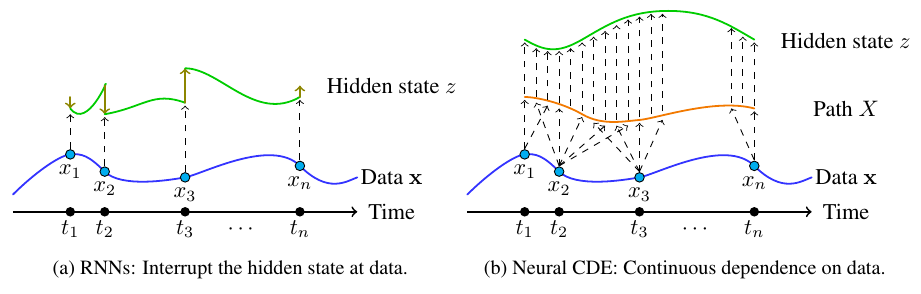

An example file of how to use torchcde is placed here in the github:
https://github.com/patrick-kidger/torchcde/blob/master/example/time_series_classification.py

In [142]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels,internal_hid_channels = 128):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.linear1 = torch.nn.Linear(hidden_channels, internal_hid_channels)
        self.linear2 = torch.nn.Linear(internal_hid_channels, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z


In [143]:
######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="linear",mode = 'coord'):
        super(NeuralCDE, self).__init__()
        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation
        self.mode = mode

    def forward(self, coeffs):
        batch_num = coeffs.size(0)
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        # print(X.interval) # [0,8] 
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        adjoint_params = tuple(self.func.parameters()) + (coeffs,)
        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval,
                              adjoint = True,
                              adjoint_params = adjoint_params,
                              method='euler',
                              )

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        if self.mode == 'coord':
          pred_y = pred_y.view(batch_num,-1,3)
        return pred_y

In [144]:
# The input channel and the output channels
# Here time is also included in this one-hot sequence
if MODE == 'coord':
    print(X.size(2),y.size(2))
else:
    print(X.size(2),y.size())

101 3


We define our own path-loss by mean of point-wise euclidean distance in the coordinate modes

In [145]:
class MyMSELoss(torch.nn.Module):
    def __init__(self):
        super(MyMSELoss, self).__init__()

    def forward(self, inputs, targets):        
        #batch_size, seq_len, channel = inputs.size()
        diff = torch.sub(inputs,targets)
        
        sqr = torch.square(diff)
        add_up = torch.sum(sqr,axis = -1)
        sqrt = torch.sqrt(add_up)
        seq_of_loss = torch.mean(sqrt,axis = -1)
        loss = torch.mean(seq_of_loss,axis = 0)

        return loss


In [146]:
if MODE == 'coord':
  model = NeuralCDE(input_channels=X.size(2), hidden_channels=8, output_channels= y.size(1) * y.size(2))
else:
  model = NeuralCDE(input_channels=X.size(2), hidden_channels=8, output_channels= y.size(1) ,mode = MODE)

optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)
l2_loss = MyMSELoss()

# Training

Now after we have these one-hot encoding of sequence along with other features, we want to turn this into the continuous path. This can be done via internal method of NeuralCDE

In [147]:
train_coeffs = torchcde.linear_interpolation_coeffs(X_train, rectilinear=0)
train_dataset = torch.utils.data.TensorDataset(train_coeffs, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

In [148]:
# GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [149]:
num_epochs = 50

If the model is already trained, we can continue our training by loading the existing model


In [150]:
PATH = "/content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/cde_model"
#model = torch.load(PATH).to(device)

In [151]:
# training_process

for epoch in range(num_epochs):
        running_loss = 0
        for i, batch in tqdm.tqdm(enumerate(train_dataloader),total = len(train_dataloader)):
            optimizer.zero_grad()
            batch_coeffs, batch_y = batch
            batch_coeffs = batch_coeffs.to(device)
            batch_coeffs.requires_grad = True
      
            batch_y = batch_y.to(device)
            pred_y = model(batch_coeffs)
            
            loss = l2_loss(pred_y,batch_y) 
     
            # Maybe we can use signature-loss instead
            running_loss += loss.item()
            
            loss.backward()

            optimizer.step()
            
        print('Training loss: {}'.format(running_loss /len(train_dataloader)))
        running_loss = 0
        torch.save(model, PATH)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored

# Testing

Now we can draw out a test input pdb. We can use the following function to reconstruct

ERROR: This script does not work! For more generation in testing, check another script called protein_inference.ipynb

In [ ]:
input_file = "T1019s2.pdb"
test_Seq,test_Backbone = get_indiv_from_pdb(input_file, path = "",mode = MODE)
_,gt_Backbone = get_indiv_from_pdb(input_file, path = "",mode = 'coord')
X_test, y_test = crop_data([torch.tensor(sequence_to_onehot(test_Seq))],[torch.tensor(test_Backbone)],WINDOW,MODE)
# WINDOW = 64
sequence_length = len(test_Backbone)
test_coeffs = torchcde.linear_interpolation_coeffs(X_test,rectilinear = 0).to(device)
pred_y = model(test_coeffs)
print(pred_y.size())

# Here, the ouput is the cropped version of pred_y
# We need to concat these together. Except the final one, we just simply construct a concatenation. 
# For the final one, we will simply connect it.

In [ ]:
DEFAULT = 120 # the default edge case angle is passed by 120
def Concat_protein(pred_y,length,sequence,mode = 'coord'):
  # length is the total length of input * 3
  if mode == 'coord':
      # the output is the coordinate version
      batch_num, cropped_length, channel = pred_y.size()
      Concat_list = []
      Cat_index = length%cropped_length
      for i in range(batch_num):
          if i == batch_num - 1:
            # the final one, we take last part
            Concat_list.append(pred_y[i, -Cat_index:,:])
          else:
            # original one, directly append
            Concat_list.append(pred_y[i,:,:])
      return torch.concat(Concat_list,dim = 0)
  else:
    # the output is the torsion angle version
    batch_num, cropped_length = pred_y.size()
    torsion_list = []
    Cat_index = length%cropped_length
    for i in range(batch_num):
      if i == batch_num - 1:
        # the final one, we take the last part
        torsion_list.append(list(pred_y[i, -Cat_index:]))
      else:
        #original one, directly concat
        torsion_list.append(list(pred_y[i,:]))
    torsion_list = [item for seq in torsion_list for item in seq]
    rearranged_list = []
    temp = None
    for i,item in enumerate(torsion_list):
      if i == 0:
        rearranged_list.append((DEFAULT,item))
      elif i == len(torsion_list) - 1:
        rearranged_list.append((item,DEFAULT))
      else:
        if temp is None:
          temp = item
        else:
          rearranged_list.append((temp,item))
          temp = None
    return Torsion_to_coord(rearranged_list,sequence)
          

In [ ]:
from PeptideBuilder import Geometry
import PeptideBuilder

def Torsion_to_coord(rearranged_list,sequence):
  # given a set of torsion angle and the corrosponding list, generate the output molecular model and calculate the coordiates
  amino_seq = (sequence)
  first_geo = Geometry.geometry(amino_seq[0])
  first_geo.phi,first_geo.psi_im1 = rearranged_list[0]

  structure = PeptideBuilder.initialize_res(first_geo)
  for i in range(1,len(sequence)):
    geo = Geometry.geometry(amino_seq[i])
    geo.phi,geo.psi_im1 = rearranged_list[i]
    PeptideBuilder.add_residue(structure, geo)
  # add terminal oxygen (OXT) to the final glycine
  PeptideBuilder.add_terminal_OXT(structure)

  pdb_file = "example.pdb"
  # Save as pdb file
  out = Bio.PDB.PDBIO()
  out.set_structure(structure)
  out.save(pdb_file)
  _,Backbone = get_indiv_from_pdb(pdb_file, path ='',mode = 'coord')
  return Backbone

In [ ]:
predict_path = Concat_protein(
    pred_y.cpu().detach(),
    sequence_length,
    test_Seq,
    mode = MODE
)
predict_path = predict_path

gt_path = torch.tensor(gt_Backbone)


Now we print the ground_truth and the reconstructed value

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1,y1,z1 = np.transpose(gt_path)
x2,y2,z2 = np.transpose(predict_path)

ax.plot(x1,y1,z1,label = "Ground_truth path")
ax.plot(x2,y2,z2,label = "Prediction path")
ax.set_title(f"Cde-fold for protein folding on {input_file}")
plt.savefig("cde-fold.png")
plt.show()